# KMeans++

### First of all, let's generate some data points

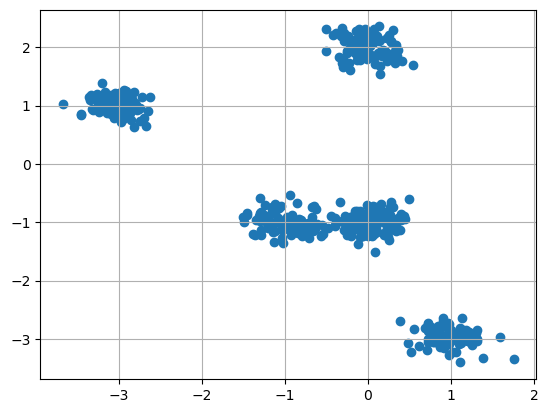

In [1]:
import numpy as np
import matplotlib.pyplot as plt

clusters = 5
n_samples = 100
n_features = 2

# Generate random positive semi-definite matrix
A = np.random.randn(2, 2) / 4
cov = A @ A.T

# Generate random means for each cluster
means = np.random.randint(low=-3, high=3, size=(clusters, 2))

# Generate samples for all clusters at once
X = np.random.multivariate_normal(np.zeros(2), cov, (clusters, n_samples))

# Add the means to each cluster's samples
X += means[:, np.newaxis, :]

# Reshape X to combine all clusters
X = X.reshape(-1, 2)

# Plot the results
plt.scatter(X[:, 0], X[:, 1])
plt.grid()
plt.show()

### Let's also copy and paste the KMeans class that we previously had so that we can inherit KMeans++ later on!

In [2]:
class KMeans:
    """
    K-means clustering algorithm implementation.

    Attributes:
        clusters (int): Number of clusters.
        centroids (np.ndarray): Cluster centroids.
        max_iter (int): Maximum number of iterations.
    """

    def __init__(self, k, max_iter=100, distance_type='euclidean'):
        """
        Initialize the KMeans instance.

        Args:
            k (int): Number of clusters.
            max_iter (int): Maximum number of iterations.
        """
        self.clusters = k
        self.centroids = None
        self.max_iter = max_iter
        self.distance_type = distance_type
        self.assignments = None
        
    def _initialize_centroids(self, X):
        """
        Initialize cluster centroids randomly within the data range.

        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).
        """
        self.centroids = np.random.uniform(
            low=np.min(X, axis=0),
            high=np.max(X, axis=0),
            size=(self.clusters, X.shape[1])
        )

    def _distance(self, X):
        """
        Calculate distance between data points and centroids.
        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).
        Returns:
            np.ndarray: Distance matrix of shape (n_samples, n_clusters).
        """
        if self.distance_type == 'manhattan':
            return np.sum(
                np.abs(X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :]), axis=2
            )
        elif self.distance_type == 'euclidean':
            return np.sqrt(
                np.sum(
                    np.power(
                        (X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :]), 2
                    ), axis=2
                )
            )
        elif self.distance_type == 'cosine':
            # Normalize the vectors
            X_normalized = X / np.linalg.norm(X, axis=1)[:, np.newaxis]
            centroids_normalized = self.centroids / np.linalg.norm(self.centroids, axis=1)[:, np.newaxis]
            
            # Calculate cosine similarity
            cosine_similarity = np.dot(X_normalized, centroids_normalized.T)
            
            # Convert to distance (1 - cosine similarity)
            return 1 - cosine_similarity
        else:
            raise ValueError(f"Unsupported distance type: {self.distance_type}")

    def _update_centroids(self, X):
        """
        Update cluster centroids based on current assignments.
        Handle empty clusters by reinitializing them.
        
        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).
        Returns:
            bool: True if centroids changed, False otherwise.
        """
        distance = self._distance(X)
        self.assignments = np.argmin(distance, axis=1)
        
        new_centroids = np.zeros_like(self.centroids)
        changed = False
        
        for i in range(self.clusters):
            cluster_points = X[self.assignments == i]
            if len(cluster_points) > 0:
                new_centroid = cluster_points.mean(axis=0)
                if not np.allclose(new_centroid, self.centroids[i]):
                    changed = True
                new_centroids[i] = new_centroid
            else:
                # Reinitialize empty cluster
                new_centroids[i] = X[np.random.choice(X.shape[0])]
                changed = True
        
        self.centroids = new_centroids
        return changed
        
        
    def fit(self, X):
        """
        Fit the K-means model to the input data.

        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).
        """
        self._initialize_centroids(X)
        
        for _ in range(self.max_iter):
            if not self._update_centroids(X):
                break
    
    def calculate_SSE(self, X):
        """
        Calculate the Mean Squared Error (MSE) for the clustering.
    
        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).
            kmeans (KMeans): Trained KMeans or KMeans++ instance.
    
        Returns:
            float: The MSE value.
        """
        distances = self._distance(X)
        sse = np.sum(np.min(distances**2, axis=1))
        mse = sse / X.shape[0]
        return mse
        
    def predict(self, X):
        """
        Predict cluster labels for input data.

        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).

        Returns:
            np.ndarray: Predicted cluster labels.
        """
        return np.argmin(self._distance(X), axis=1)

In [3]:
## Inheriting KMeans++ from KMeans

In [4]:
class KMeansPlusPlus(KMeans):
    """
    K-means++ clustering algorithm implementation.
    Inherits from KMeans and only changes the initialization method.
    """

    def _initialize_centroids(self, X):
        """
        Initialize cluster centroids using the K-means++ method.
        
        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).
        """
        n_samples, n_features = X.shape
        centroids = np.zeros((self.clusters, n_features))
        
        # Randomly choose the first centroid
        centroids[0] = X[np.random.randint(n_samples)]
        
        # Choose the remaining centroids
        for i in range(1, self.clusters):
            # Compute distances from points to the centroids
            distances = np.min(np.sum((X[:, np.newaxis] - centroids[:i])**2, axis=2), axis=1)
            
            # Choose the next centroid with probability proportional to distance squared
            probs = distances / distances.sum()
            cumprobs = np.cumsum(probs)
            r = np.random.rand()
            ind = np.searchsorted(cumprobs, r)
            centroids[i] = X[ind]
        
        self.centroids = centroids

### Example usage of KMeans++ with Euclidean distance

Sum of Squared Errors: 0.07379872795237286


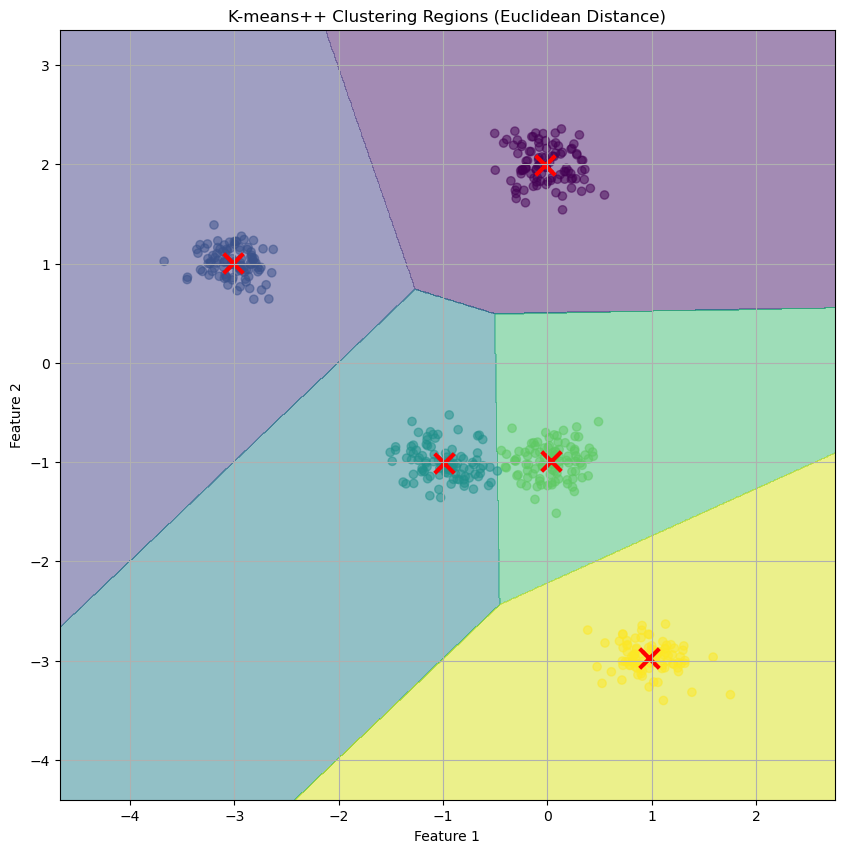

In [5]:
# Initiate and fit
kmeansplus = KMeansPlusPlus(k=5, max_iter=50, distance_type='euclidean')
kmeansplus.fit(X)

sse = kmeansplus.calculate_SSE(X)
print(f"Sum of Squared Errors: {sse}")

# Create a meshgrid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))

# Flatten the grid to pass into predict
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Predict assignments for each point in the meshgrid
region_assignments = kmeansplus.predict(grid_points)

# Reshape the assignment array to match the meshgrid shape
region_assignments = region_assignments.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 10))

# Plot the regions
plt.contourf(xx, yy, region_assignments, alpha=0.5)

# Plot the centroids
plt.scatter(kmeansplus.centroids[:, 0], kmeansplus.centroids[:, 1], marker='x', color='red', s=100, linewidths=3)
# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=kmeansplus.assignments, alpha=0.5)

# Plot centroids
plt.scatter(kmeansplus.centroids[:, 0], kmeansplus.centroids[:, 1], marker='x', color='red', s=200, linewidths=3)

plt.grid(True)
plt.title('K-means++ Clustering Regions (Euclidean Distance)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Example usage of KMeans++ with Manhattan distance

Sum of Squared Errors: 0.12124921500414859


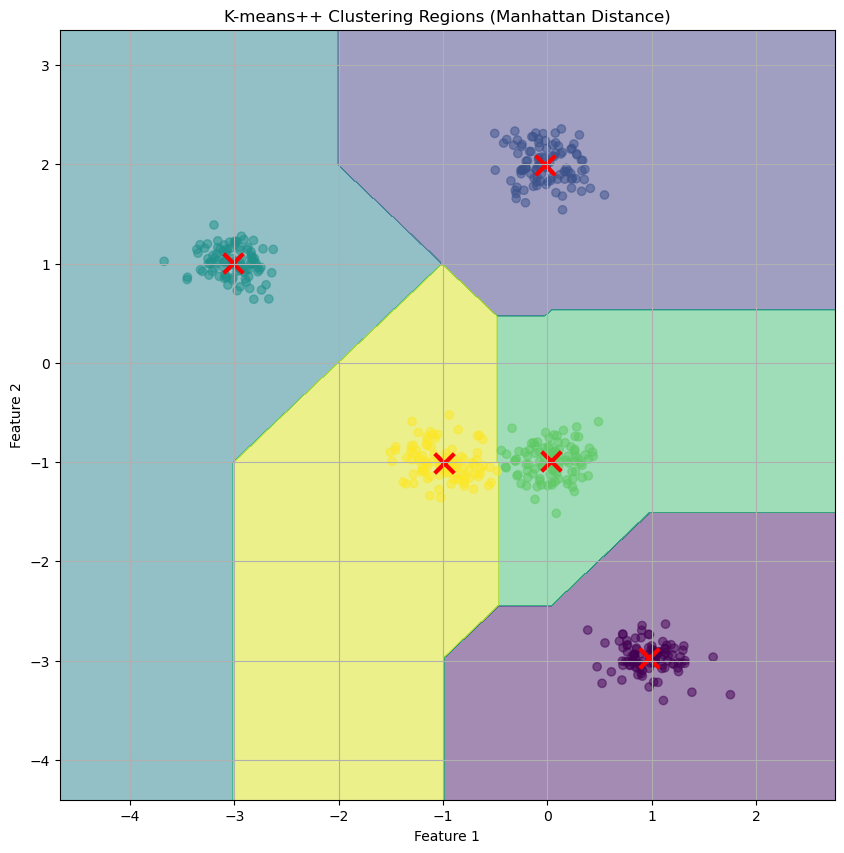

In [6]:
# Initiate and fit
kmeansplus = KMeansPlusPlus(k=5, max_iter=50, distance_type='manhattan')
kmeansplus.fit(X)

sse = kmeansplus.calculate_SSE(X)
print(f"Sum of Squared Errors: {sse}")

# Predict assignments for each point in the meshgrid
region_assignments = kmeansplus.predict(grid_points)

# Reshape the assignment array to match the meshgrid shape
region_assignments = region_assignments.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 10))

# Plot the regions
plt.contourf(xx, yy, region_assignments, alpha=0.5)

# Plot the centroids
plt.scatter(kmeansplus.centroids[:, 0], kmeansplus.centroids[:, 1], marker='x', color='red', s=100, linewidths=3)
# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=kmeansplus.assignments, alpha=0.5)

# Plot centroids
plt.scatter(kmeansplus.centroids[:, 0], kmeansplus.centroids[:, 1], marker='x', color='red', s=200, linewidths=3)

plt.grid(True)
plt.title('K-means++ Clustering Regions (Manhattan Distance)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Example usage of KMeans++ with Cosine distance

Sum of Squared Errors: 0.00013969331325492607


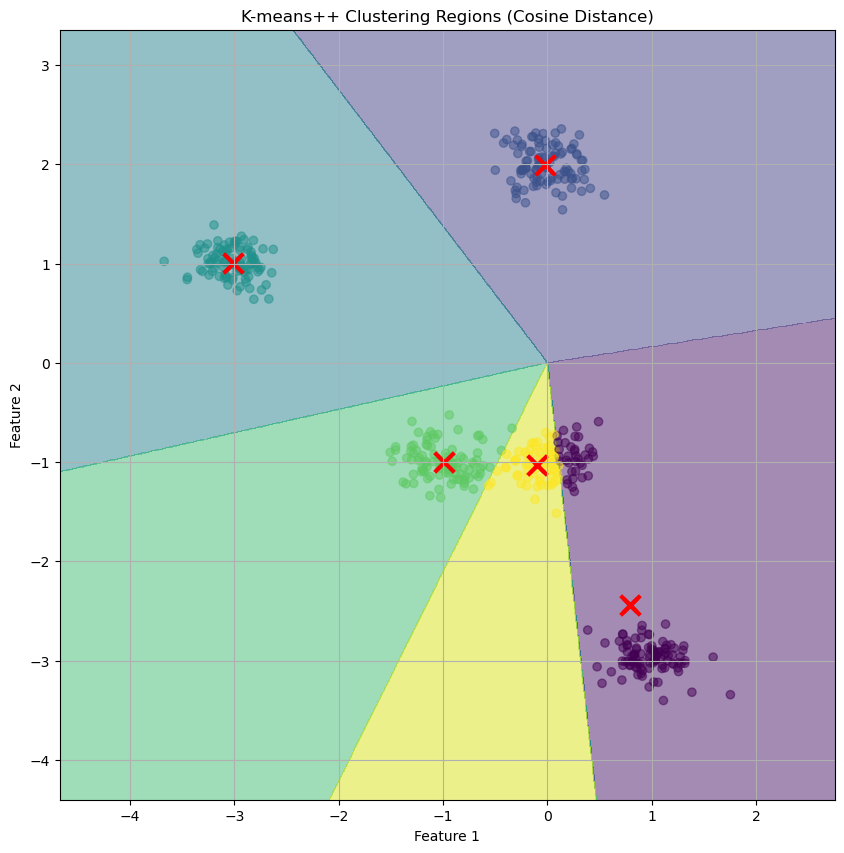

In [7]:
# Initiate and fit
kmeansplus = KMeansPlusPlus(k=5, max_iter=50, distance_type='cosine')
kmeansplus.fit(X)

sse = kmeansplus.calculate_SSE(X)
print(f"Sum of Squared Errors: {sse}")

# Predict assignments for each point in the meshgrid
region_assignments = kmeansplus.predict(grid_points)

# Reshape the assignment array to match the meshgrid shape
region_assignments = region_assignments.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 10))

# Plot the regions
plt.contourf(xx, yy, region_assignments, alpha=0.5)

# Plot the centroids
plt.scatter(kmeansplus.centroids[:, 0], kmeansplus.centroids[:, 1], marker='x', color='red', s=100, linewidths=3)
# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=kmeansplus.assignments, alpha=0.5)

# Plot centroids
plt.scatter(kmeansplus.centroids[:, 0], kmeansplus.centroids[:, 1], marker='x', color='red', s=200, linewidths=3)

plt.grid(True)
plt.title('K-means++ Clustering Regions (Cosine Distance)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Note that since we are re-initializing the centroids, we cannot compare the distance measures directly. Nonetheless, the graphs clearly demonstrate how each distance measure is.